In [1]:
import os, gc, torch, PIL, pickle

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from data.constants import XAMI_MIMIC_PATH
from utils.plot import plot_loss, plot_train_val_evaluators, plot_evaluator
from PIL import Image
from models.load import get_model_label, get_model_name, get_current_epoch, get_dataset_label, get_trained_model

from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS
import utils.print as print_f
from utils.init import reproducibility, clean_memory_get_device

# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class TrainedModels(Enum):

    with_clinical = "val_ar_0_7430_ap_0_5567_test_ar_0_7974_ap_0_5392_epoch29_WithClincal_05-02-2022 17-07-17_with_clinical"

    with_clinical_final = "val_ar_0_7269_ap_0_4601_test_ar_0_6710_ap_0_4286_epoch100_WithClincal_05-02-2022 19-03-30_with_clinical"

    without_clinical = "val_ar_0_5377_ap_0_2981_test_ar_0_4515_ap_0_2716_epoch30_WithoutClincal_05-02-2022 12-32-56_without_clinical"
    without_clinical_final = "val_ar_0_5053_ap_0_2754_test_ar_0_4265_ap_0_2605_epoch100_WithoutClincal_05-02-2022 14-17-08_without_clinical"

    
    # pretrained_resnet50_without_clinical_ap = "val_ar_0_5272_ap_0_2396_test_ar_0_6170_ap_0_1962_epoch44_WithoutClincal_04-19-2022 07-35-55_pretrained_resnet50_without_clinical"
    # pretrained_resnet50_without_clinical_ar = "val_ar_0_5272_ap_0_2396_test_ar_0_6170_ap_0_1962_epoch44_WithoutClincal_04-19-2022 07-35-46_pretrained_resnet50_without_clinical"
    # pretrained_resnet50_without_clinical_final = "val_ar_0_2560_ap_0_1522_test_ar_0_3072_ap_0_1295_epoch200_WithoutClincal_04-20-2022 18-32-16_pretrained_resnet50_without_clinical"
    
    # pretrained_resnet50_with_clinical_ap = "val_ar_0_3842_ap_0_2467_test_ar_0_3799_ap_0_1727_epoch106_WithClincal_04-20-2022 19-09-13_pretrained_resnet50_with_clinical"
    # pretrained_resnet50_with_clinical_ar = "val_ar_0_5164_ap_0_1869_test_ar_0_5086_ap_0_1718_epoch64_WithClincal_04-19-2022 19-33-35_pretrained_resnet50_with_clinical"
    # pretrained_resnet50_with_clinical_final = "val_ar_0_2849_ap_0_1805_test_ar_0_3793_ap_0_1925_epoch200_WithClincal_04-21-2022 04-07-24_pretrained_resnet50_with_clinical"

    # custom_with_clinical_no_pretrained_ar = "val_ar_0_5220_ap_0_2513_test_ar_0_5590_ap_0_2442_epoch150_WithClincal_04-13-2022 20-13-47_custom_with_clinical_no_pretrained"
    # custom_with_clinical_no_pretrained_ap = "val_ar_0_4554_ap_0_2582_test_ar_0_5254_ap_0_2405_epoch139_WithClincal_04-13-2022 19-05-08_custom_with_clinical_no_pretrained"
    # custom_with_clinical_no_pretrained_final = "val_ar_0_4523_ap_0_2251_test_ar_0_5103_ap_0_2464_epoch200_WithClincal_04-14-2022 01-32-28_custom_with_clinical_no_pretrained"

    # custom_without_clinical_no_pretrained_ar = "val_ar_0_5645_ap_0_2659_test_ar_0_6263_ap_0_2533_epoch145_WithoutClincal_04-13-2022 08-47-34_custom_without_clinical_no_pretrained"
    # custom_without_clinical_no_pretrained_ap = "val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-28_custom_without_clinical_no_pretrained"
    # custom_without_clinical_no_pretrained_final = "val_ar_0_3757_ap_0_1699_test_ar_0_4421_ap_0_1819_epoch200_WithoutClincal_04-13-2022 14-58-52_custom_without_clinical_no_pretrained"

    # custom_without_clinical_swim_ap = "val_ar_0_5307_ap_0_2054_test_ar_0_5321_ap_0_1726_epoch87_WithoutClincal_04-17-2022 06-51-10_custom_without_clinical_swim"
    # custom_without_clinical_swim_ar = "val_ar_0_5313_ap_0_1540_test_ar_0_5906_ap_0_1486_epoch59_WithoutClincal_04-17-2022 05-48-30_custom_without_clinical_swim"
    # custom_without_clinical_swim_final = "val_ar_0_2175_ap_0_1390_test_ar_0_2231_ap_0_0901_epoch200_WithoutClincal_04-17-2022 10-49-59_custom_without_clinical_swim"

    # custom_with_clinical_swim_ap = "val_ar_0_5081_ap_0_2210_test_ar_0_5392_ap_0_1725_epoch95_WithClincal_04-17-2022 15-26-02_custom_with_clinical_swim"
    # custom_with_clinical_swim_ar = "val_ar_0_5377_ap_0_1821_test_ar_0_4561_ap_0_1193_epoch67_WithClincal_04-17-2022 14-02-28_custom_with_clinical_swim"
    # custom_with_clinical_swim_final = "val_ar_0_2752_ap_0_1293_test_ar_0_3391_ap_0_1097_epoch200_WithClincal_04-17-2022 20-31-24_custom_with_clinical_swim"


In [4]:
# searching_str = ""

# for i, trained_model in enumerate(TrainedModels):
#         idx = i+1
#         if idx % 3 == 0:
#             searching_str+= f"\"{trained_model.value}\""
#             print(searching_str)
#             searching_str = ""
#             print("\n\n")
#         else:
#             searching_str+= f"\"{trained_model.value}\" OR "

In [5]:
naming_map = {
    TrainedModels.with_clinical: "with_clinical_best",
    TrainedModels.with_clinical_final: "with_clinical_final",
    TrainedModels.without_clinical: "without_clinical_best",
    TrainedModels.without_clinical_final: "without_clinical_final",
}

# naming_map = {
#     TrainedModels.pretrained_resnet50_without_clinical_ap: "pretrained_resnet50_without_clinical_ap",
#     TrainedModels.pretrained_resnet50_without_clinical_ar: "pretrained_resnet50_without_clinical_ar",
#     TrainedModels.pretrained_resnet50_without_clinical_final: "pretrained_resnet50_without_clinical_final",
#     TrainedModels.pretrained_resnet50_with_clinical_ap: "pretrained_resnet50_with_clinical_ap",
#     TrainedModels.pretrained_resnet50_with_clinical_ar: "pretrained_resnet50_with_clinical_ar",
#     TrainedModels.pretrained_resnet50_with_clinical_final: "pretrained_resnet50_with_clinical_final",
#     TrainedModels.custom_with_clinical_no_pretrained_ar: "unpretrained_resnet50_with_clinical_ar",
#     TrainedModels.custom_with_clinical_no_pretrained_ap: "unpretrained_resnet50_with_clinical_ap",
#     TrainedModels.custom_with_clinical_no_pretrained_final: "unpretrained_resnet50_with_clinical_final",
#     TrainedModels.custom_without_clinical_no_pretrained_ar: "unpretrained_resnet50_without_clinical_ar",
#     TrainedModels.custom_without_clinical_no_pretrained_ap: "unpretrained_resnet50_without_clinical_ap",
#     TrainedModels.custom_without_clinical_no_pretrained_final: "unpretrained_resnet50_without_clinical_final",
#     TrainedModels.custom_without_clinical_swim_ap: "unpretrained_swin_without_clinical_ap",
#     TrainedModels.custom_without_clinical_swim_ar: "unpretrained_swin_without_clinical_ar",
#     TrainedModels.custom_without_clinical_swim_final: "unpretrained_swin_without_clinical_final",
#     TrainedModels.custom_with_clinical_swim_ap: "unpretrained_swin_with_clinical_ap",
#     TrainedModels.custom_with_clinical_swim_ar: "unpretrained_swin_with_clinical_ar",
#     TrainedModels.custom_with_clinical_swim_final: "unpretrained_swin_with_clinical_final",
# }


In [6]:
def get_thrs_evaluation_df(models: List[TrainedModels] , suffix, disease="all", thrs = 0.5,):
    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{suffix}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data

    return  pd.DataFrame(
            [
                {
                    "model": str(select_model).split(".")[-1],
                    **all_models_eval_data[select_model.value][thrs][0],
                } for select_model in models
            ]
        )[['model','ap', 'ar']]

In [7]:
# from models.load import TrainedModels
from typing import List

def plot_iou_result_old(models: List[TrainedModels] , datasets, disease="all", figsize=(10, 10), include_recall=False):

    cm = plt.get_cmap('rainbow')
    NUM_COLORS = len(models)

    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{datasets}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data


    fig, (precision_ax, recall_ax) = plt.subplots(
        2, figsize=figsize, dpi=80, sharex=True,
    )

    fig.suptitle(f"{datasets}")

    precision_ax.set_title("Average Precision")
    precision_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for select_model in models:
        precision_ax.plot(
            all_models_eval_data[select_model.value].keys(),
            [v[0]["ap"] for v in all_models_eval_data[select_model.value].values()],
            marker="o",
            label=get_model_label(select_model, naming_map=naming_map),
            # color="darkorange",
        )
    precision_ax.legend(loc="upper right")

    recall_ax.set_title("Average Recall")
    recall_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    for select_model in models:
        recall_ax.plot(
            all_models_eval_data[select_model.value].keys(),
            [v[0]["ar"] for v in all_models_eval_data[select_model.value].values()],
            marker="o",
            label=get_model_label(select_model, naming_map=naming_map),
            # color="darkorange",
        )

    recall_ax.legend(loc="upper right")
    recall_ax.set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig

In [8]:
# from models.load import TrainedModels
from typing import List

def plot_iou_result(
    models: List[TrainedModels],
    datasets,
    disease="all",
    figsize=(10, 10),
    include_recall=False,
):

    cm = plt.get_cmap("rainbow")
    NUM_COLORS = len(models)

    all_models_eval_data = { dataset: {} for dataset in datasets}

    for select_model in models:
        for dataset in datasets:
            with open(
                os.path.join(
                    "eval_results", f"{select_model.value}_{dataset}_{disease}.pkl",
                ),
                "rb",
            ) as f:
                eval_data = pickle.load(f)
                all_models_eval_data[dataset][select_model.value] = eval_data

    fig, axes = plt.subplots(
        len(datasets), 2 if include_recall else 1,
        figsize=figsize,
        dpi=80,
        sharex=True,
        squeeze=False
    )

    for i, dataset in enumerate(datasets):
        axes[i,0].set_title(f"[{dataset}] - Average Precision")
        axes[i,0].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for select_model in models:
            axes[i,0].plot(
                all_models_eval_data[dataset][select_model.value].keys(),
                [v[0]["ap"] for v in all_models_eval_data[dataset][select_model.value].values()],
                marker="o",
                label=get_model_label(select_model, naming_map=naming_map),
                # color="darkorange",
            )
        axes[i,0].legend(loc="upper right")

        if (include_recall):

            axes[i, 1].set_title(f"[{dataset}] - Average Recall")
            axes[i, 1].set_prop_cycle(
                "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
            )

            for select_model in models:
                axes[i, 1].plot(
                    all_models_eval_data[dataset][select_model.value].keys(),
                    [v[0]["ar"] for v in all_models_eval_data[dataset][select_model.value].values()],
                    marker="o",
                    label=get_model_label(select_model, naming_map=naming_map),
                    # color="darkorange",
                )

            axes[i, 1].legend(loc="upper right")
            axes[i, 1].set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


In [33]:
def showModelOnDatasets(
    select_model, datasets, disease="all", figsize=(10, 10), include_recall=False
):
    """
    This function used for detecting the overfitting dataset.    
    """
    cm = plt.get_cmap("gist_rainbow")
    NUM_COLORS = len(datasets)

    all_models_eval_data = {}
    for dataset in datasets:
        with open(
            os.path.join(
                "eval_results", f"{select_model.value}_{dataset}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[dataset] = eval_data

    fig, axes = plt.subplots(
        2 if include_recall else 1, figsize=figsize, dpi=80, sharex=True, squeeze=False,
    )

    axes = axes[0]

    fig.suptitle(get_model_label(select_model, naming_map=naming_map))

    axes[0].set_title("Average Precision")
    axes[0].set_prop_cycle(
        "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
    )

    for dataset in datasets:
        axes[0].plot(
            all_models_eval_data[dataset].keys(),
            [v[0]["ap"] for v in all_models_eval_data[dataset].values()],
            marker="o",
            label=dataset,
            # color="darkorange",
        )
    axes[0].legend(loc="upper right")

    if include_recall:
        axes[1].set_title("Average Recall")
        axes[1].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for dataset in datasets:
            axes[1].plot(
                all_models_eval_data[dataset].keys(),
                [v[0]["ar"] for v in all_models_eval_data[dataset].values()],
                marker="o",
                label=dataset,
                # color="darkorange",
            )

        axes[1].legend(loc="upper right")
        axes[1].set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


In [10]:
def plot_training_progress(trained_models):
    for trained_model in trained_models:
        _, train_info, _ = get_trained_model(
            trained_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            image_size=512,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.05,
        )

        print_f.print_title("Training Info")
        print(train_info)

        model_setup = train_info.model_setup

        if model_setup.record_training_performance:
            plot_train_val_evaluators(
                    train_info.train_evaluators,
                    train_info.val_evaluators,
                    areaRng="all",
                    iouThr=0.5,
                    maxDets=10,
                )
        else:
            plot_evaluator(
                    train_info.val_evaluators, iouThr=0.5, areaRng="all", maxDets=10,
                )


In [11]:
def print_train_infos(trained_models):
    for trained_model in trained_models:
        _, train_info, _ = get_trained_model(
            trained_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            image_size=512,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.05,
        )

        print_f.print_title("Training Info")
        print(train_info)


In [12]:
from utils.train import num_params

def print_num_params(trained_models):
    for trained_model in trained_models:
        model, train_info, _ = get_trained_model(
            trained_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            image_size=512,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.05,
        )

        print(f"| [{train_info.model_setup.name}] | #Params: [{num_params(model):,}] |")


In [13]:
all_final_models = [
    TrainedModels.pretrained_resnet50_with_clinical_final,
    TrainedModels.pretrained_resnet50_without_clinical_final,
    TrainedModels.custom_with_clinical_no_pretrained_final,
    TrainedModels.custom_without_clinical_no_pretrained_final,
    TrainedModels.custom_with_clinical_swim_final,
    TrainedModels.custom_without_clinical_swim_final,
]

all_ap_models = [
    TrainedModels.pretrained_resnet50_with_clinical_ap,
    TrainedModels.pretrained_resnet50_without_clinical_ap,
    TrainedModels.custom_with_clinical_no_pretrained_ap,
    TrainedModels.custom_without_clinical_no_pretrained_ap,
    TrainedModels.custom_with_clinical_swim_ap,
    TrainedModels.custom_without_clinical_swim_ap,
]

all_ar_models = [
    TrainedModels.pretrained_resnet50_with_clinical_ar,
    TrainedModels.pretrained_resnet50_without_clinical_ar,
    TrainedModels.custom_with_clinical_no_pretrained_ar,
    TrainedModels.custom_without_clinical_no_pretrained_ar,
    TrainedModels.custom_with_clinical_swim_ar,
    TrainedModels.custom_without_clinical_swim_ar,
]

training_recorded_models = [
    TrainedModels.pretrained_resnet50_with_clinical_final,
    TrainedModels.pretrained_resnet50_without_clinical_final,
    TrainedModels.custom_with_clinical_no_pretrained_final,
    TrainedModels.custom_without_clinical_no_pretrained_final,
]


# Findings

## I. Pretrained and Unpretrained.
---
In this experiment, I ran the pretrained model for 100 epoch and unpretrained model for 200 because the unpretained model take a longer to converge. In the figure below, the first we shows the training progress in four different models. 

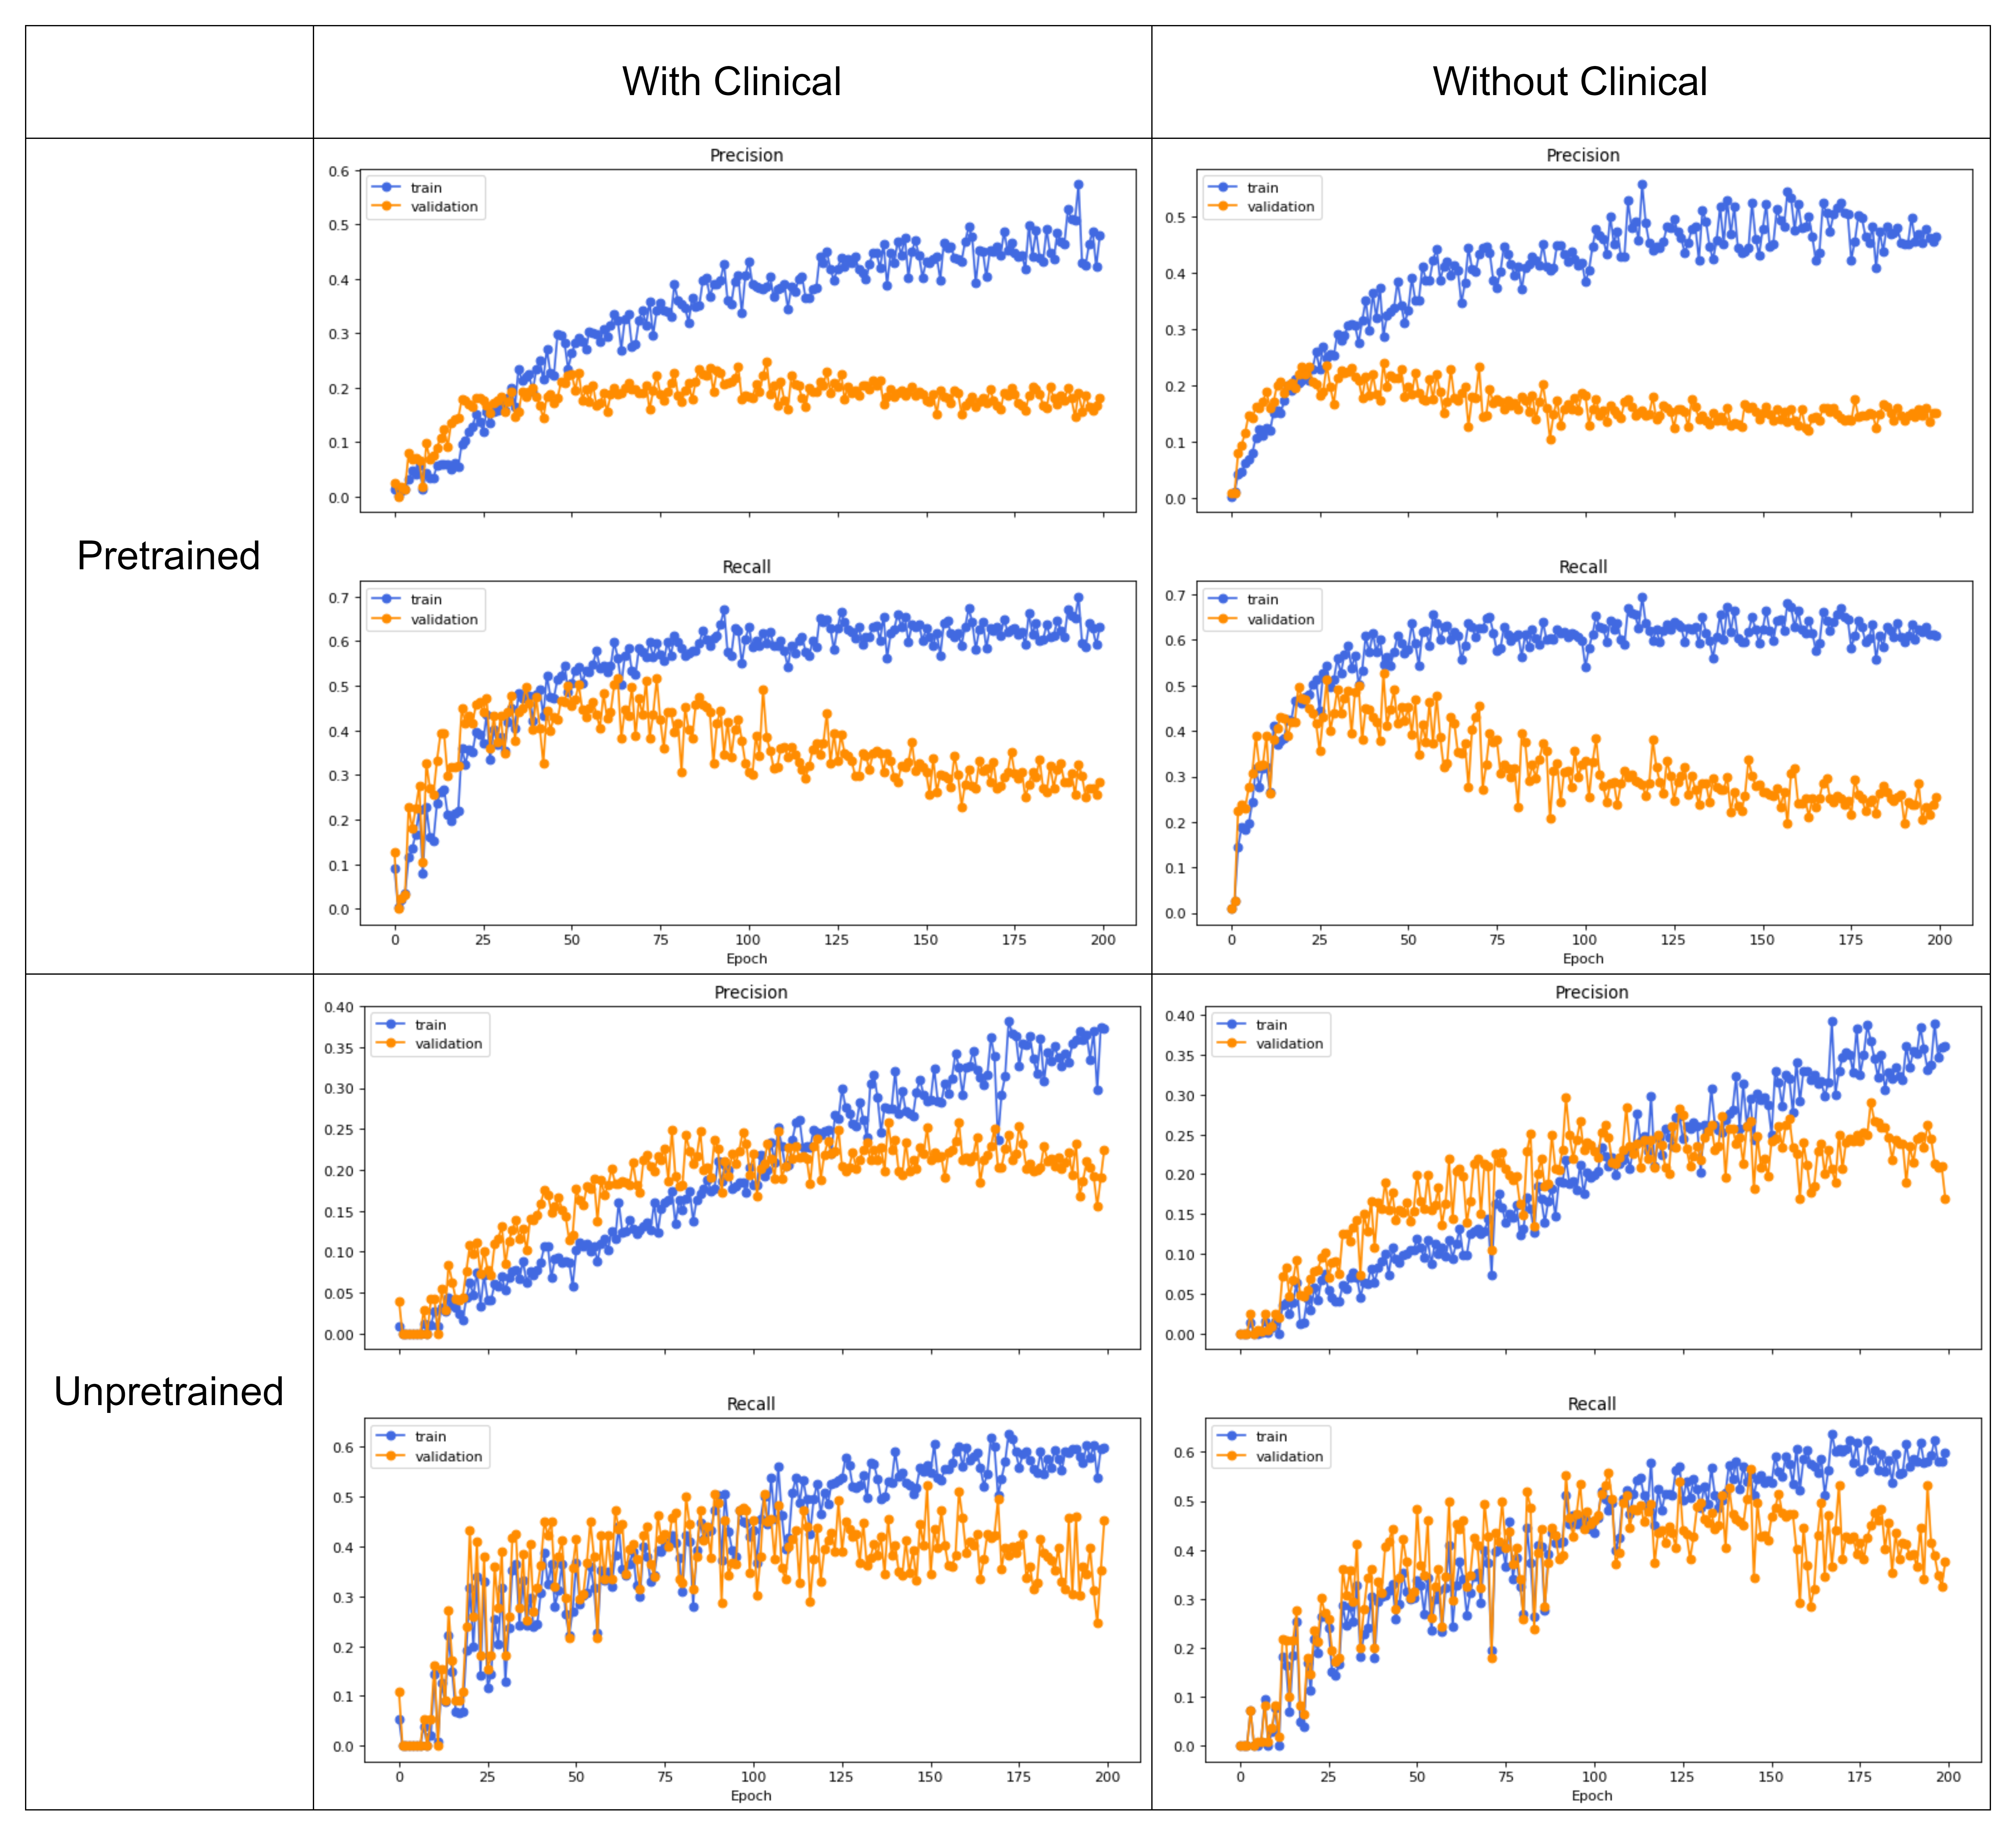

In [14]:
# plot_training_progress(training_recorded_models)
Image.open('charts\eval\\training_progress\TrainingProgress.png')

# Figure 1

### 1. The unpretrained model took a longer time to converge.
The pretrained models took only around 20 epochs to reach their best AP performance on the validation dataset. On the other hand, the unpretrained models took 80 epochs. The pretrained model already has the ability to extract basic patterns in the first few layers of ResNet; therefore, the model only has to fine tune the weights. And, this is one of the benefit of using transfer learning.


### 2. The model trained with clinical data took a longer time to converge.
From those two pretrained models, we can notice that the one trained with clinical data took a longer time to reach best validation pefromance, and it didnt' even converge at 100 epoch. The model without clinical data contains 43,943,923 trainable parameters, but when we introduce clinical NN and fusion operations to the model, the number of parameters increase to 62,334,753, which is 40% more than the model without clinical. Therefore, it's not suprising that the model will need more time to train the clinical NN and fusion NN, which don't have the pretrained weights.

### 3. Both pretrained an unpretrained have serious overfitting problem.
No matter including the clinical data or not, both pretrained and unpretrained have serious overfitting problem. We have applied serveral generalization, but only **Early Stop** strategy work in our case. We consider this overfitting issue is caused by the size of our dadtaset.

- [x] Increase the learning rate.
    The gradient explosion happened. The lost value became ”nan”.
- [x] Increase the weight decay (L2 regularization).
    The model converged slower but resulted in same overfitting problem.  
- [x] shrink the model size.
    We can only shrink the size of the clinical model, because we’re using the pretrained model, which means their dimension has been determined in previous training session. And most of the parameters come from the ResNet50 (image model) we use. We could only shrink the model size from 54M to 52M.
- [x] Increase dropout rate.
    We tried increasing the dropout rate to 0.5, but we get the same result as “increase the weight decay”.
- [O] Early Stop
    It compromise the performance a lot, and we’re not satisfied with the result.



In [13]:
### Number of trainable parameters
print_num_params(
    [
        # TrainedModels.pretrained_resnet50_with_clinical_final,
        # TrainedModels.pretrained_resnet50_without_clinical_final,
        TrainedModels.custom_with_clinical_no_pretrained_final,
        TrainedModels.custom_without_clinical_no_pretrained_final,
        TrainedModels.custom_with_clinical_swim_final,
        TrainedModels.custom_without_clinical_swim_final,
    ]
)


Load custom model
Using ResNet50 as backbone
Not using pretrained model.
Found optimizer for this model.
Model size: 62,334,753
Using SGD as optimizer with lr=0.0005
| [custom_with_clinical_no_pretrained] | #Params: [62,334,753] |
Load custom model
Using ResNet50 as backbone
Not using pretrained model.
Found optimizer for this model.
Model size: 43,943,923
Using SGD as optimizer with lr=0.0005
| [custom_without_clinical_no_pretrained] | #Params: [43,943,923] |
Load custom model
Using SwinTransformer as backbone
Found optimizer for this model.
Model size: 65,786,139
Using AdamW as optimizer with lr=0.0001
| [custom_with_clinical_swim] | #Params: [65,786,139] |
Load custom model
Using SwinTransformer as backbone
Found optimizer for this model.
Model size: 47,395,309
Using AdamW as optimizer with lr=0.0001
| [custom_without_clinical_swim] | #Params: [47,395,309] |


## Performace on train, validation and test datasets
---

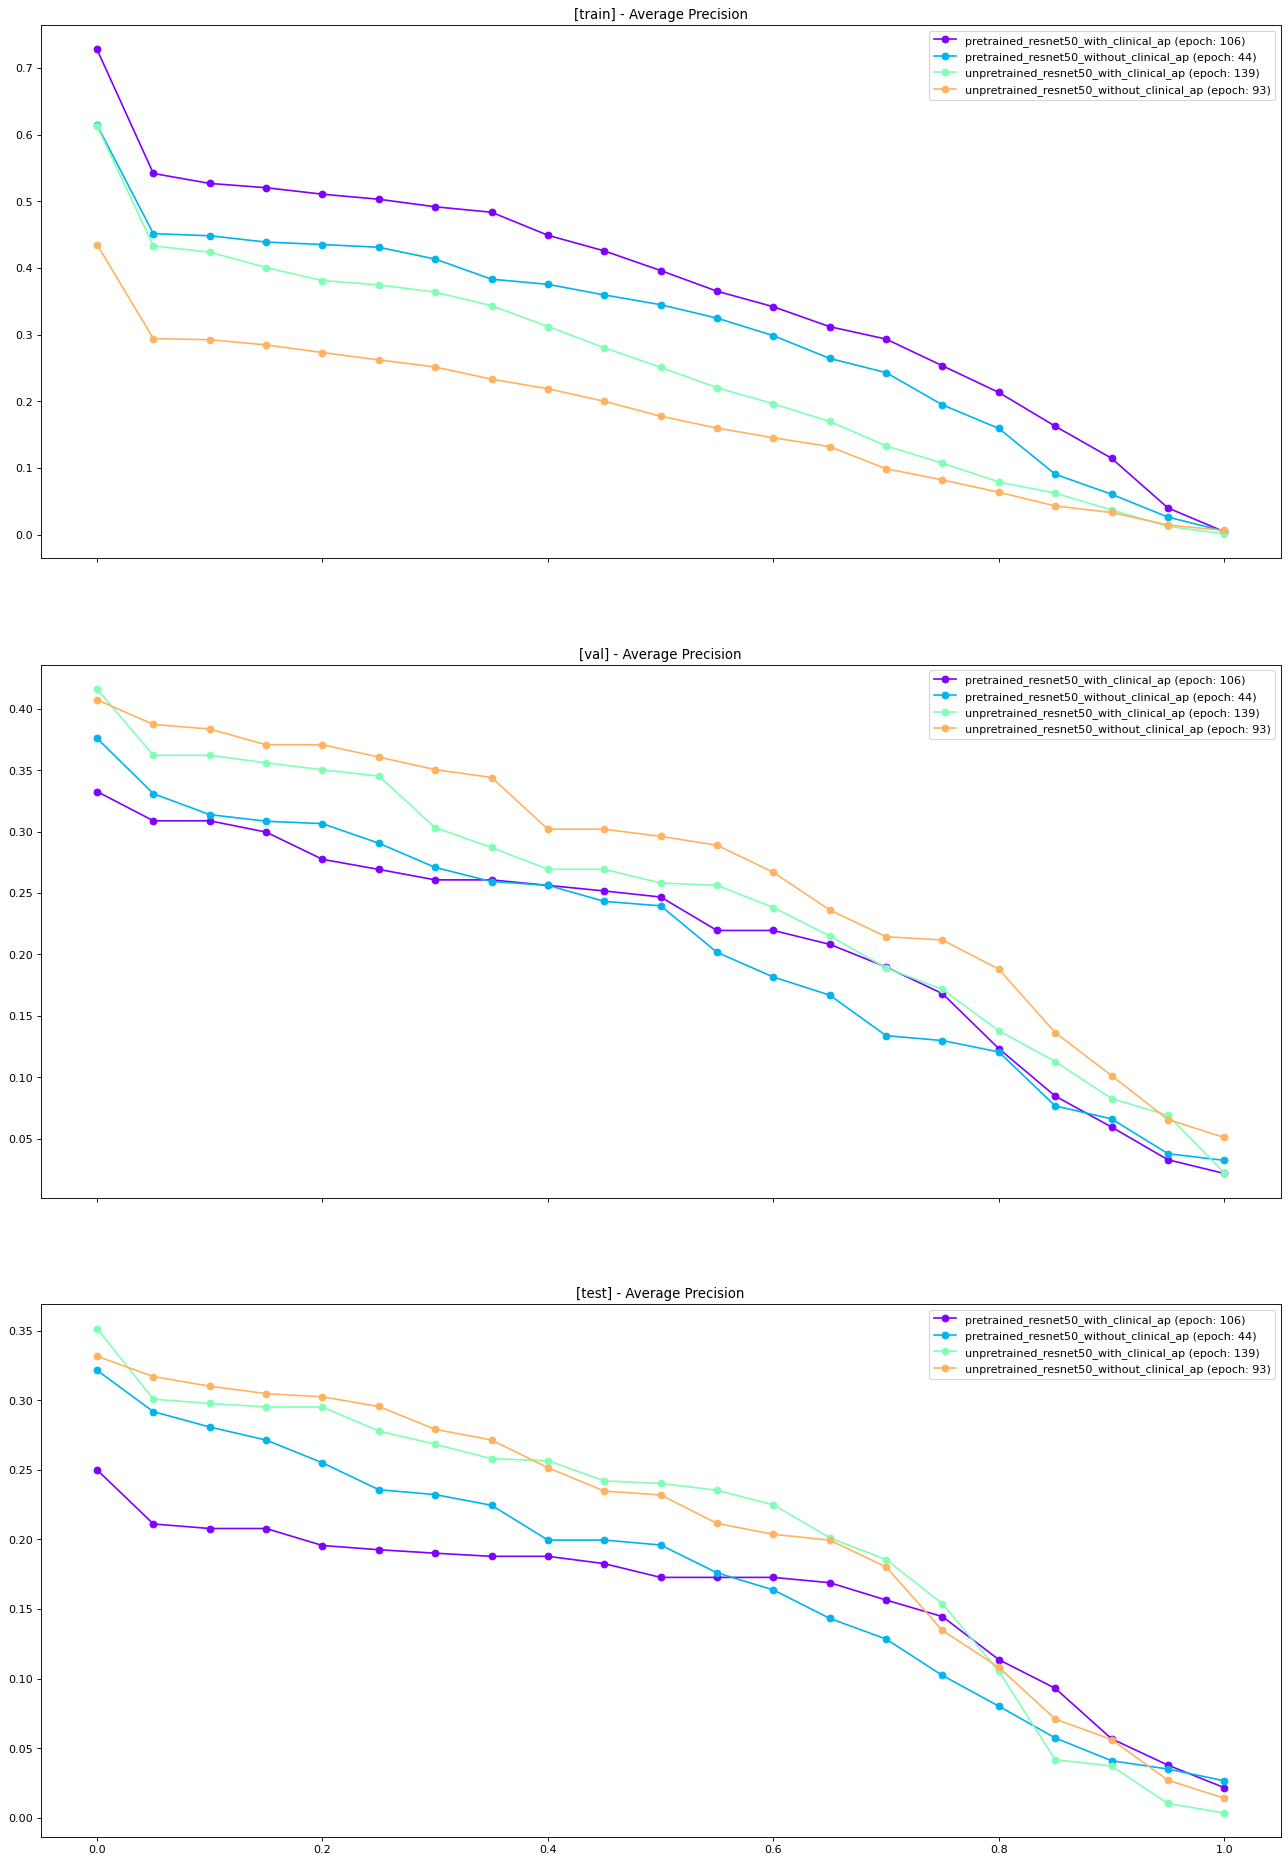

In [21]:
_ = plot_iou_result([
    TrainedModels.pretrained_resnet50_with_clinical_ap,
    TrainedModels.pretrained_resnet50_without_clinical_ap,
    TrainedModels.custom_with_clinical_no_pretrained_ap,
    TrainedModels.custom_without_clinical_no_pretrained_ap,
    # TrainedModels.custom_with_clinical_swim_ap,
    # TrainedModels.custom_without_clinical_swim_ap,
], ['train', 'val', 'test'], figsize=(20,30), include_recall=False)

# Figure 2

### 1. The pretrained model fit better on the training dataset.
As the first figure above shows, the pretrained model (with/without clinical) perform better than the unpretrained model. However, the training progress in the previous section also shows the unpretrained model haven't converge at 200th epoch, which means the model can further improve the performance if we continue traininig them for more epochs.

### 2. The model with clinical data perform better on the training dataset.
Same as our assumption, the model with clinical data should perform better since the extra features will allow the model to classify the input better. 

### 3. Different situation for validation and test dataset.
However, the 1st and 2nd points above don't work the same in validation and test datasets. The validation and test AP curves show the opposite results to training AP curve, which further indicates the overfitting problem we have with this dataset. 

### 4. The overfitting occurs later with on models trained with clinical data. 
In order to overcome the overfitting issue we have with this dataset, we decided to adopt early stop strategy, which saves the model when it reach best validation performance. The pretrained and unpretrained models trained with clinical data reached their best validation performance at .  

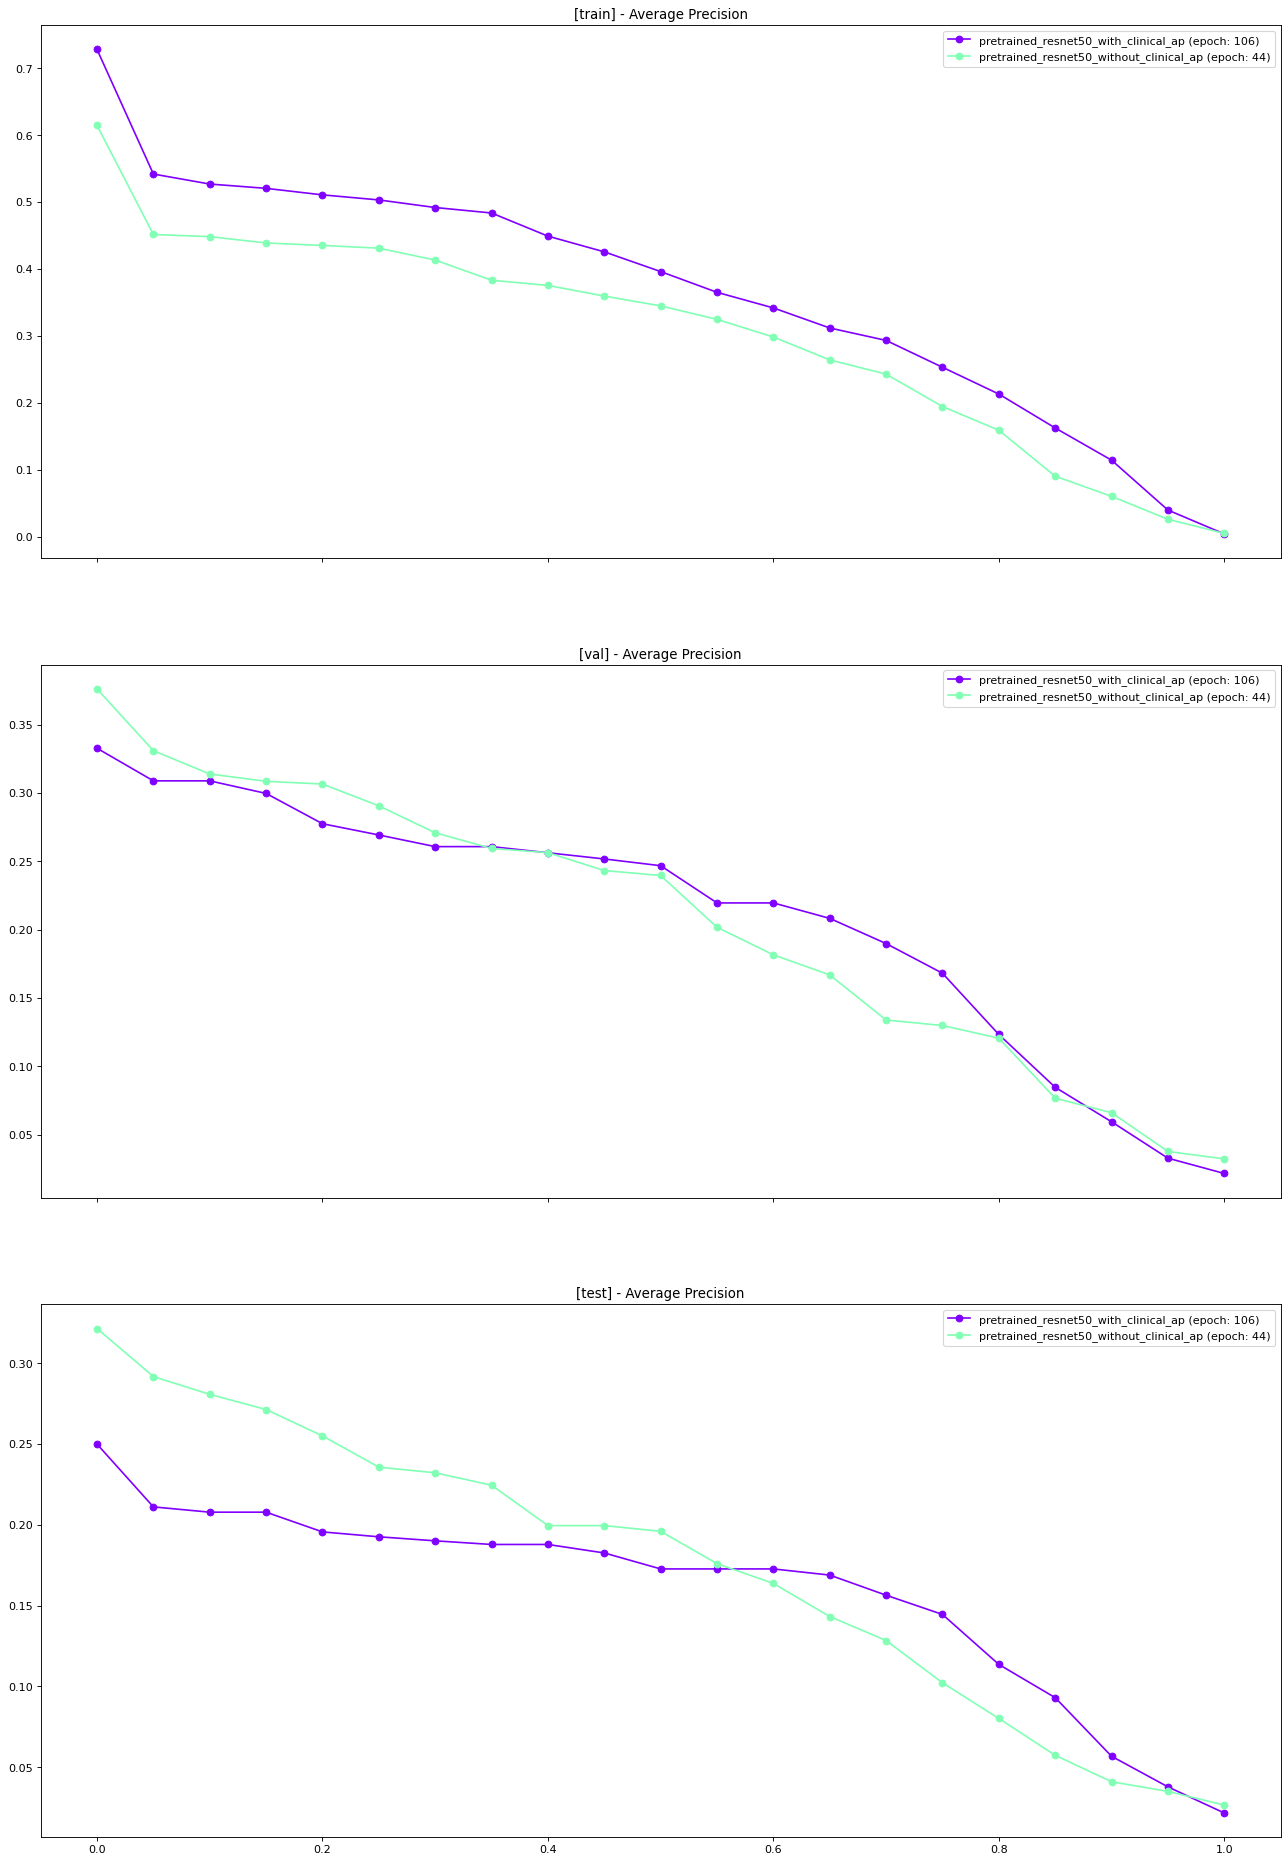

In [25]:
_ = plot_iou_result([
    TrainedModels.pretrained_resnet50_with_clinical_ap,
    TrainedModels.pretrained_resnet50_without_clinical_ap,
    # TrainedModels.custom_with_clinical_no_pretrained_ap,
    # TrainedModels.custom_without_clinical_no_pretrained_ap,
    # TrainedModels.custom_with_clinical_swim_ap,
    # TrainedModels.custom_without_clinical_swim_ap,
], ['train', 'val', 'test'], figsize=(20,30), include_recall=False)

# Figure 3


### 5. For the pretrained models, the model uses clinical data perform better at higher IoBB threshold.
This effect indicats that the clinical data helps the model to overlap the prediction bounding boxes more precisely on the ground truth. 



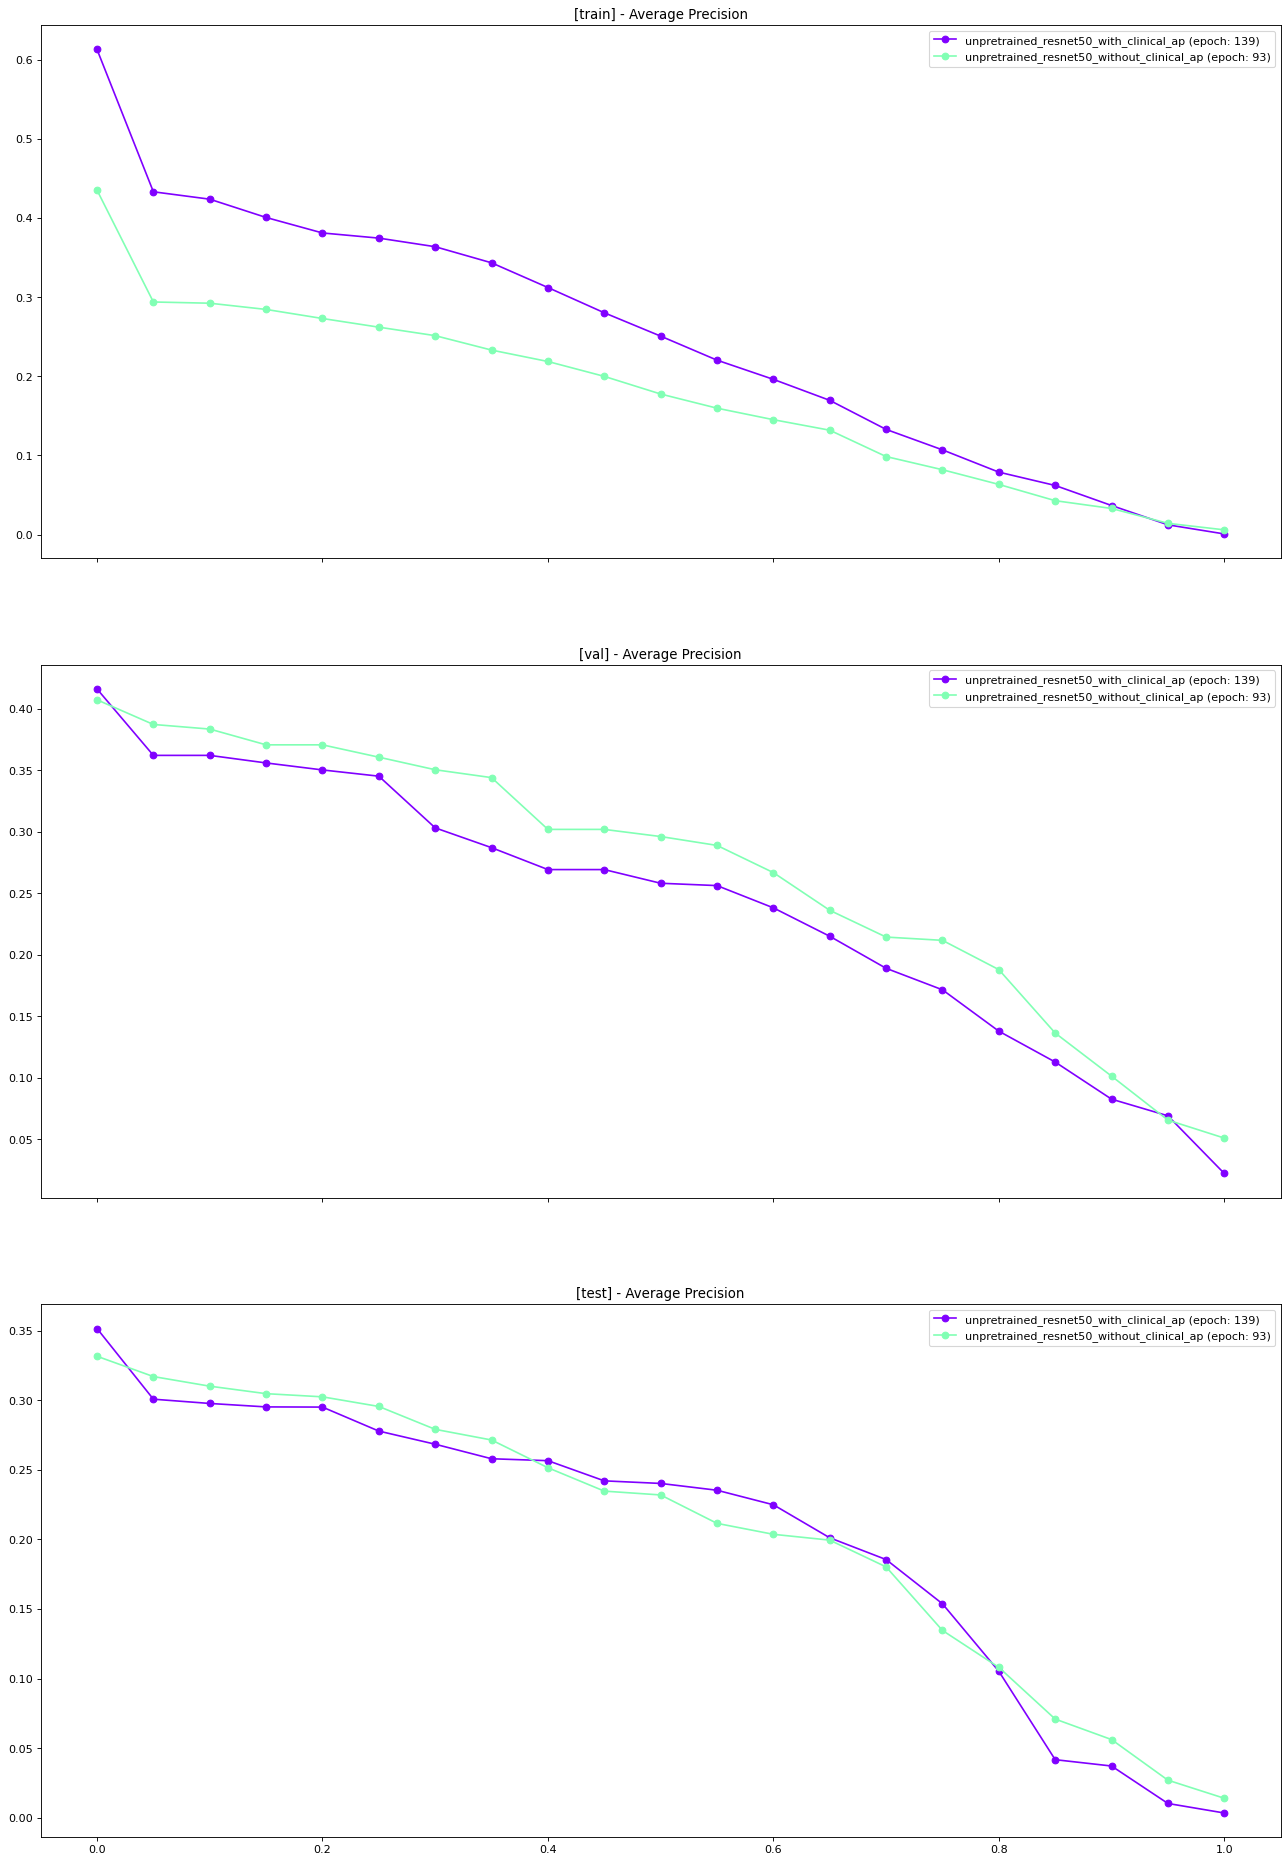

In [26]:
_ = plot_iou_result([
    # TrainedModels.pretrained_resnet50_with_clinical_ap,
    # TrainedModels.pretrained_resnet50_without_clinical_ap,
    TrainedModels.custom_with_clinical_no_pretrained_ap,
    TrainedModels.custom_without_clinical_no_pretrained_ap,
    # TrainedModels.custom_with_clinical_swim_ap,
    # TrainedModels.custom_without_clinical_swim_ap,
], ['train', 'val', 'test'], figsize=(20,30), include_recall=False)

# Figure 4

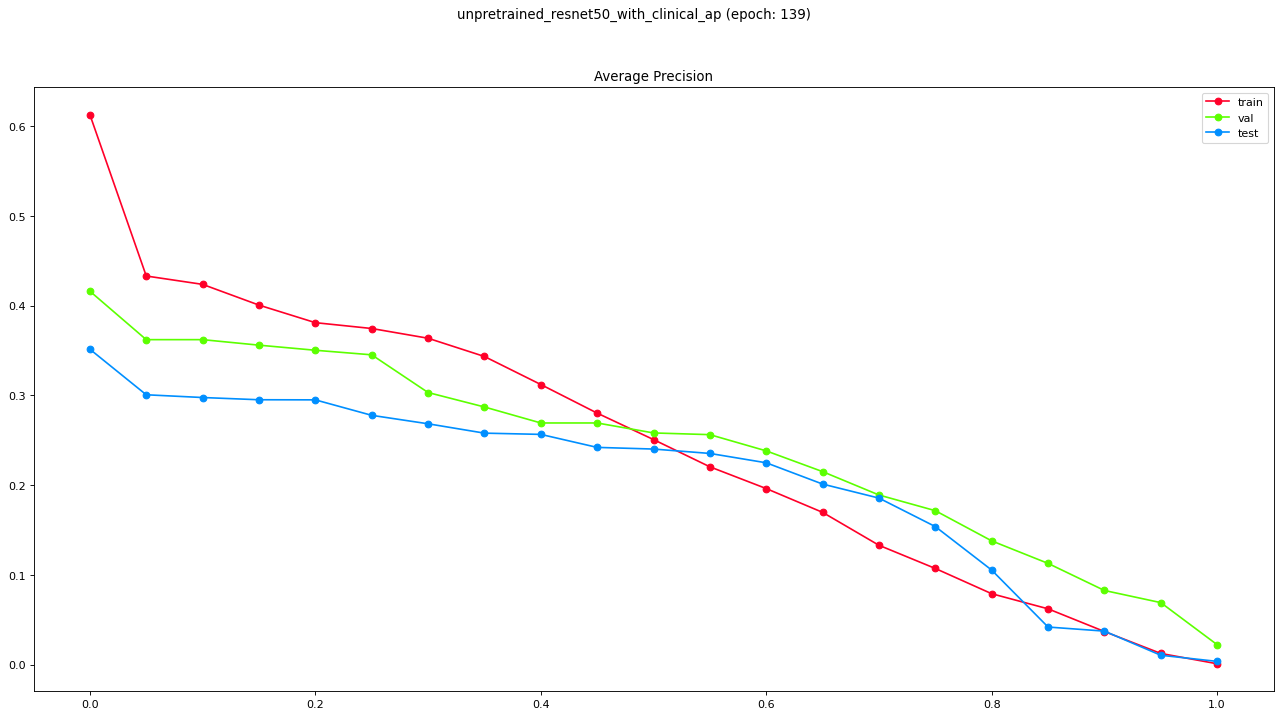

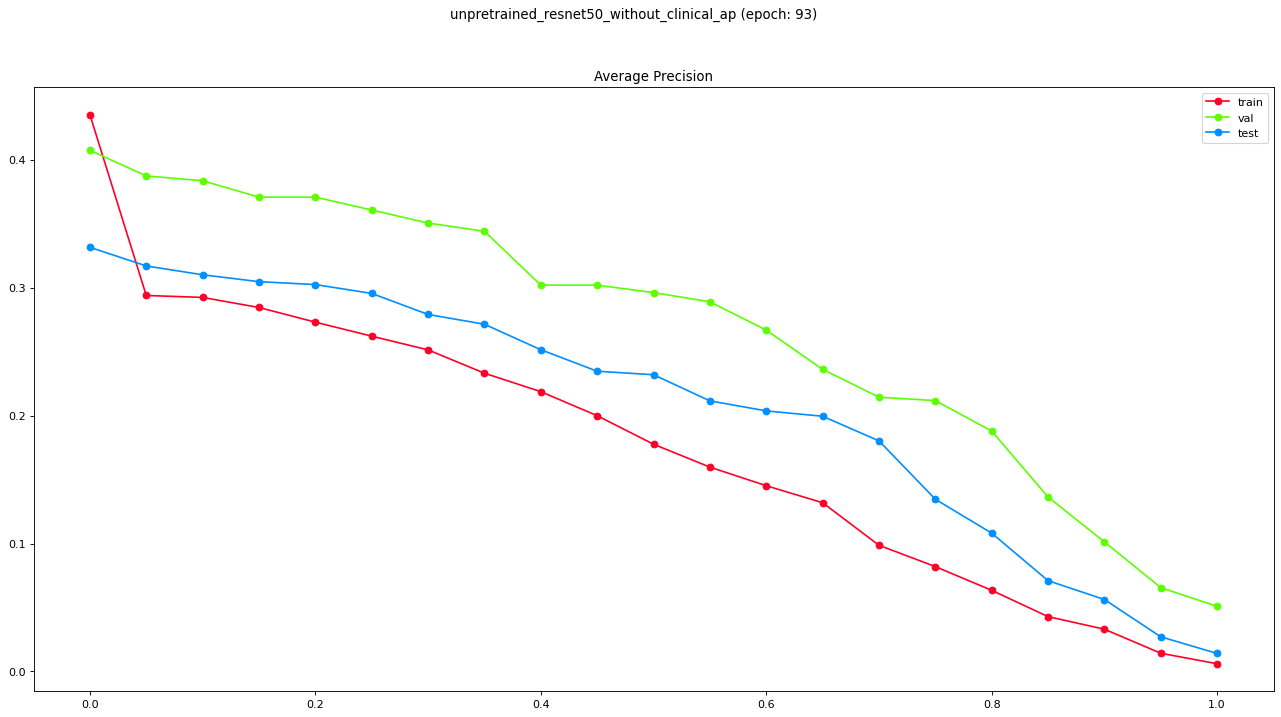

In [35]:
for model in [
    # TrainedModels.pretrained_resnet50_with_clinical_ap,
    # TrainedModels.pretrained_resnet50_without_clinical_ap,
    TrainedModels.custom_with_clinical_no_pretrained_ap,
    TrainedModels.custom_without_clinical_no_pretrained_ap,
    # TrainedModels.custom_with_clinical_swim_ap,
    # TrainedModels.custom_without_clinical_swim_ap,
]:

    _ = showModelOnDatasets(model, ['train', 'val', 'test'], figsize=(20,10))

# Figure 5

From figure 4 and 5, we can see the model with clinical data peforms better on the training data, but worse on validation and test dataset. On the other hand, the model wihtout clinical has worst performance on the training dataset. And, this indicates the model with clinical has more overfitting than desired, and the model without overfitting. 

-> Althought the clinical data allow the model to seperate and identify the classes easier, it also introduce more overfitting to the model.